In [1]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

print('Библиотеки загружены')

Библиотеки загружены


In [2]:
reg_data = pd.read_csv('audi.csv')
class_data = pd.read_csv('weatherAUS.csv')

# Regression

In [3]:
reg_data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [4]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


In [5]:
reg_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,22896.685039,24827.244001,126.011436,50.770022,1.930709
std,2.167494,11714.841888,23505.257205,67.170294,12.949782,0.602957
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15130.750000,5968.750000,125.000000,40.900000,1.500000
50%,2017.000000,20200.000000,19000.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36464.500000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


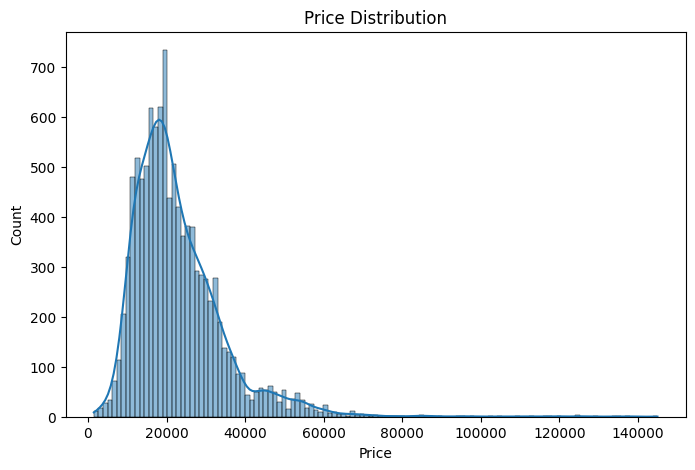

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(reg_data['price'], bins='auto', kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [7]:
reg_data = reg_data[reg_data['price'] < 75000]

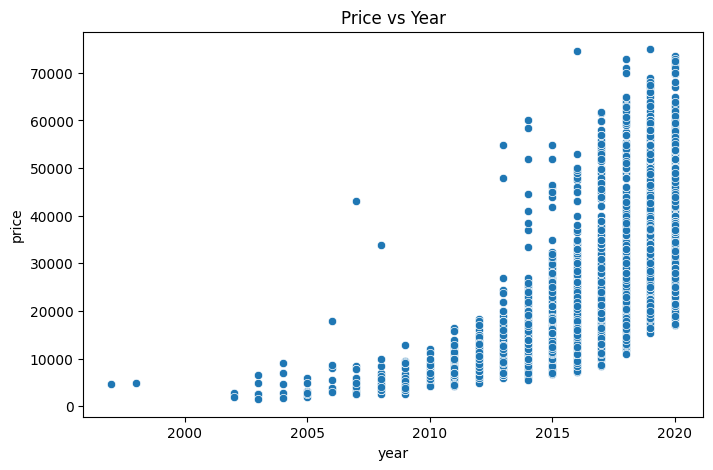

In [8]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=reg_data, x='year', y='price')
plt.title('Price vs Year')
plt.show()

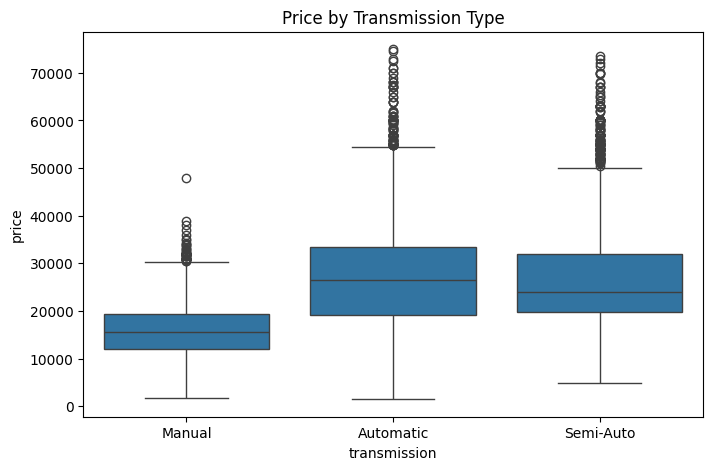

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(data=reg_data, x='transmission', y='price')
plt.title('Price by Transmission Type')
plt.show()

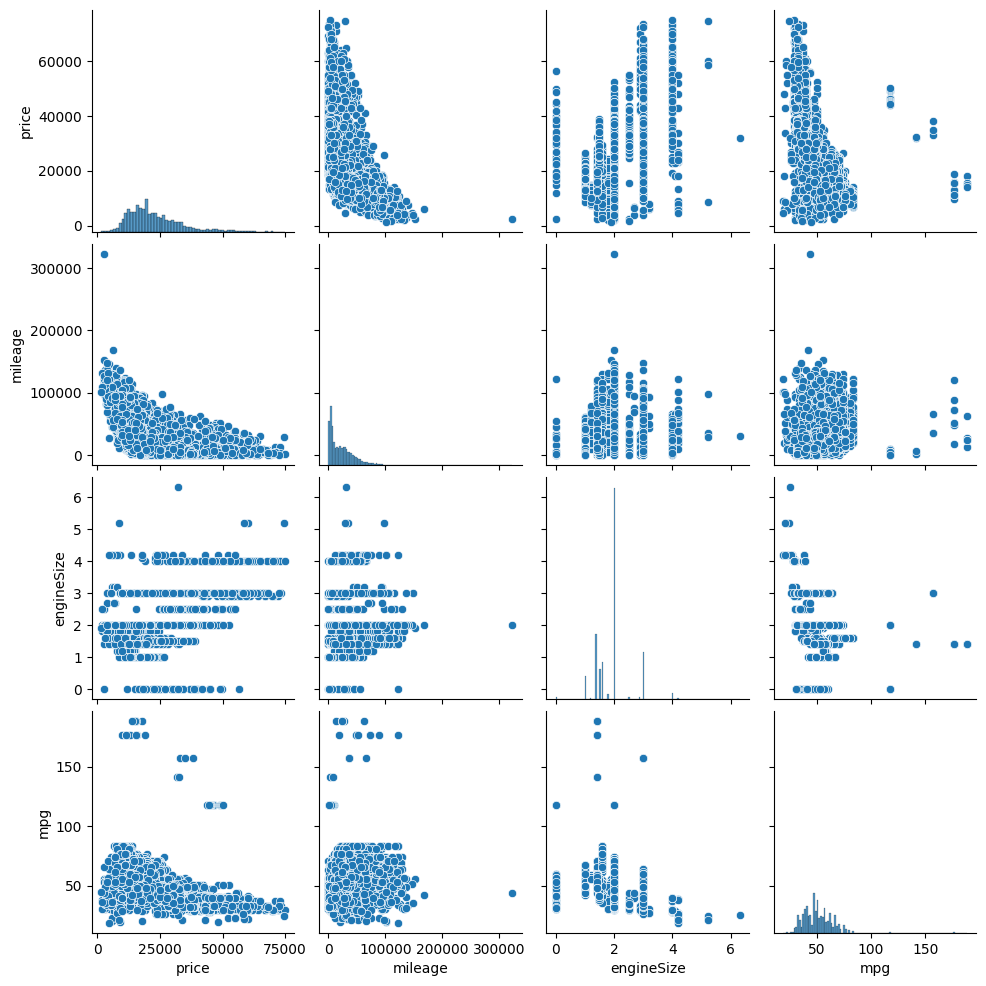

In [10]:
sns.pairplot(reg_data[['price', 'mileage', 'engineSize', 'mpg']])
plt.show()

In [11]:
str_cols = ['model', 'transmission', 'fuelType']
num_cols = ['year', 'mileage', 'engineSize', 'mpg', 'tax']
target_col = 'price'

In [12]:
te = TargetEncoder()
scaler = StandardScaler()

In [13]:
X = reg_data.drop('price', axis=1)
y = reg_data['price']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

In [16]:
transformer = ColumnTransformer(transformers=[
    ('scaler', scaler, num_cols),
    ('cat', te, str_cols)
])


full_pipe = Pipeline([('preprocessing', transformer), ('model', model)])


full_pipe.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
y_pred = full_pipe.predict(X_test)

In [18]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))

RMSE: 2069.2437716842423
MAE: 1464.6422513103078
R2: 0.9618480992664767
MSE: 4281769.786654029


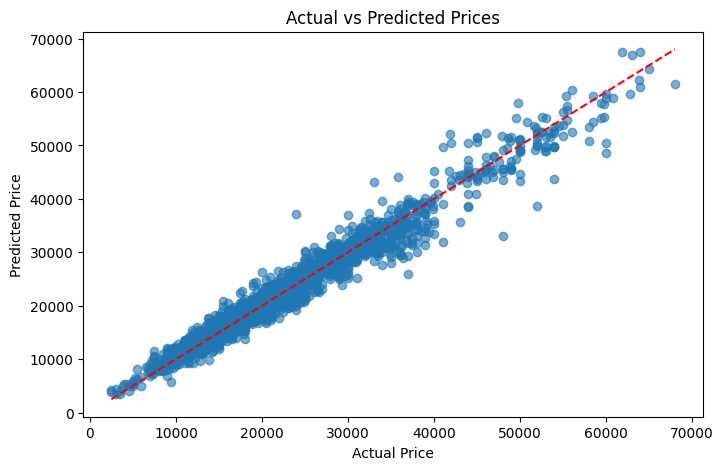

In [19]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [20]:
param_dist = {
    'model__n_estimators': list(range(10, 201, 20)),
    'model__max_depth': [None] + list(range(5, 21)),
    'model__min_samples_split': list(range(2, 11)),
    'model__min_samples_leaf': list(range(1, 6)),
    'model__max_features': ['sqrt', 'log2']
}

rs = RandomizedSearchCV(full_pipe, param_distributions=param_dist, n_iter=15, cv=5,
                    scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

In [21]:
rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
print('Best CV score (neg RMSE):', rs.best_score_)

Best params: {'model__n_estimators': 70, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20}
Best CV score (neg RMSE): -3662.7631538476003


In [22]:
# Оценка на тестовой выборке
best_pipe = rs.best_estimator_
y_pred_rs = best_pipe.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_rs)))
print('Test MAE:', mean_absolute_error(y_test, y_pred_rs))
print('Test R2:', r2_score(y_test, y_pred_rs))

Test RMSE: 3334.185408472849
Test MAE: 2184.269842263383
Test R2: 0.9009459221559889


In [23]:
class RandomForestRegressorCustom:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, max_features='sqrt', random_state=None):
        self.n_estimators = int(n_estimators)
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.random_state = random_state
        self.trees_ = []
        self.n_features_in_ = None

    def _mse(self, y):
        if len(y) == 0:
            return 0.0
        return np.mean((y - np.mean(y)) ** 2)

    def _build_tree(self, X, y, depth=0):
        """Построить одно дерево решений"""
        node = {}
        n_samples = X.shape[0]
        node['n_samples'] = n_samples
        node['value'] = np.mean(y)

        # Критерии остановки
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or n_samples <= 2 * self.min_samples_leaf:
            node['is_leaf'] = True
            return node

        best_feat, best_thr, best_gain = None, None, 0.0
        parent_mse = self._mse(y)

        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        if self.max_features == 'sqrt':
            n_features_to_try = max(1, int(np.sqrt(n_features)))
        elif self.max_features == 'log2':
            n_features_to_try = max(1, int(np.log2(n_features)))
        else:
            n_features_to_try = n_features
        
        feature_indices = np.random.choice(n_features, n_features_to_try, replace=False)

        for j in feature_indices:
            xj = X[:, j]
            order = np.argsort(xj)
            x_sorted = xj[order]
            y_sorted = y[order]

            uniq = np.unique(x_sorted)
            if len(uniq) == 1:
                continue
            thresholds = (uniq[:-1] + uniq[1:]) / 2.0

            for thr in thresholds:
                left_mask = xj <= thr
                right_mask = ~left_mask
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)

                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue

                mse_left = self._mse(y[left_mask])
                mse_right = self._mse(y[right_mask])
                weighted_mse = (n_left * mse_left + n_right * mse_right) / n_samples
                gain = parent_mse - weighted_mse

                if gain > best_gain:
                    best_gain = gain
                    best_feat = j
                    best_thr = thr

        if best_feat is None or best_gain <= 0:
            node['is_leaf'] = True
            return node

        # Разбиваем данные
        left_mask = X[:, best_feat] <= best_thr
        right_mask = ~left_mask
        node['is_leaf'] = False
        node['feature'] = best_feat
        node['threshold'] = best_thr
        node['left'] = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return node

    def fit(self, X, y):
        X_arr = X.values if hasattr(X, 'values') else np.asarray(X)
        y_arr = y.values if hasattr(y, 'values') else np.asarray(y)

        if X_arr.ndim == 1:
            X_arr = X_arr.reshape(-1, 1)

        self.n_features_in_ = X_arr.shape[1]
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        n_samples = X_arr.shape[0]
        
        # Обучаем несколько деревьев на случайных подвыборках (bootstrap)
        for i in range(self.n_estimators):
            # Bootstrap sample
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X_arr[indices].astype(float)
            y_bootstrap = y_arr[indices].ravel().astype(float)
            
            # Строим дерево на этой выборке
            tree = self._build_tree(X_bootstrap, y_bootstrap, depth=0)
            self.trees_.append(tree)
        
        return self

    def _predict_row(self, row, tree):
        """Предсказание для одной строки на одном дереве"""
        node = tree
        while not node.get('is_leaf', True):
            if row[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node.get('value', 0.0)

    def predict(self, X):
        if not self.trees_:
            raise RuntimeError("Model has not been fitted yet.")
        
        Xq = X.values if hasattr(X, 'values') else np.asarray(X)
        if Xq.ndim == 1:
            Xq = Xq.reshape(1, -1)
        
        # Усредняем предсказания всех деревьев
        predictions = []
        for row in Xq:
            row_preds = np.array([self._predict_row(row, tree) for tree in self.trees_])
            predictions.append(np.mean(row_preds))
        
        return np.array(predictions, dtype=float)

In [24]:
transformer = ColumnTransformer(transformers=[
    ('scaler', scaler, num_cols),
    ('cat', te, str_cols)
])

full_pipe_custom = Pipeline([('preprocessing', transformer), ('model', RandomForestRegressorCustom(n_estimators=50, max_depth=10, random_state=42))])
full_pipe_custom.fit(X_train, y_train)
y_pred_custom = full_pipe_custom.predict(X_test)
print('Test RMSE custom (RandomForest):', np.sqrt(mean_squared_error(y_test, y_pred_custom)))
print('Test MAE custom:', mean_absolute_error(y_test, y_pred_custom))
print('Test R2 custom:', r2_score(y_test, y_pred_custom))

Test RMSE custom (RandomForest): 6126.911820177099
Test MAE custom: 4460.2543848558935
Test R2 custom: 0.6655154009810935


## Добавим пару новых фич

### Датасет был обновлён в 2020 году, поэтому возраст считается относительно 2021, чтобы не было деления на ноль

In [25]:
X['age'] = 2021 - X['year']

In [26]:
X['MileagePerYear'] = X['mileage'] / X['age']

In [27]:
X.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,age,MileagePerYear
0,A1,2017,Manual,15735,Petrol,150,55.4,1.4,4,3933.75
1,A6,2016,Automatic,36203,Diesel,20,64.2,2.0,5,7240.60
2,A1,2016,Manual,29946,Petrol,30,55.4,1.4,5,5989.20
3,A4,2017,Automatic,25952,Diesel,145,67.3,2.0,4,6488.00
4,A3,2019,Manual,1998,Petrol,145,49.6,1.0,2,999.00


In [28]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
str_cols = X.select_dtypes(include=['object']).columns.tolist()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
transformer = ColumnTransformer(transformers=[
    ('scaler', scaler, num_cols),
    ('cat', te, str_cols)
])

model = RandomForestRegressor(n_estimators=100, random_state=42)


full_pipe = Pipeline([('preprocessing', transformer), ('model', model)])

In [31]:
param_dist = {
    'model__n_estimators': list(range(10, 201, 20)),
    'model__max_depth': [None] + list(range(5, 21)),
    'model__min_samples_split': list(range(2, 11)),
    'model__min_samples_leaf': list(range(1, 6)),
    'model__max_features': ['sqrt', 'log2']
}

rs = RandomizedSearchCV(full_pipe, param_distributions=param_dist, n_iter=15, cv=5,
                    scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

In [32]:
rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
print('Best CV score (neg RMSE):', rs.best_score_)

Best params: {'model__n_estimators': 70, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20}
Best CV score (neg RMSE): -3627.817704575088


In [33]:
# Оценка на тестовой выборке
best_pipe = rs.best_estimator_
y_pred_rs = best_pipe.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_rs)))
print('Test MAE:', mean_absolute_error(y_test, y_pred_rs))
print('Test R2:', r2_score(y_test, y_pred_rs))

Test RMSE: 3361.9362278957724
Test MAE: 2242.431481714298
Test R2: 0.8992901826482138


# Classification

In [34]:
class_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [35]:
class_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [36]:
class_data.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [37]:
class_data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


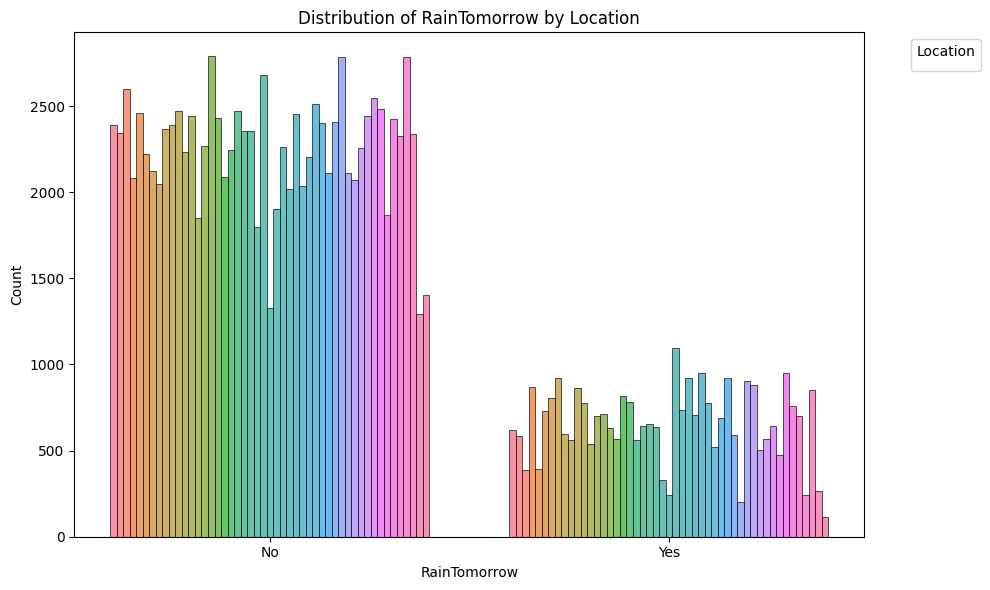

In [38]:
plt.figure(figsize=(10,6))
sns.histplot(data=class_data, x='RainTomorrow', hue='Location', multiple='dodge', shrink=0.8)
plt.title('Distribution of RainTomorrow by Location')
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

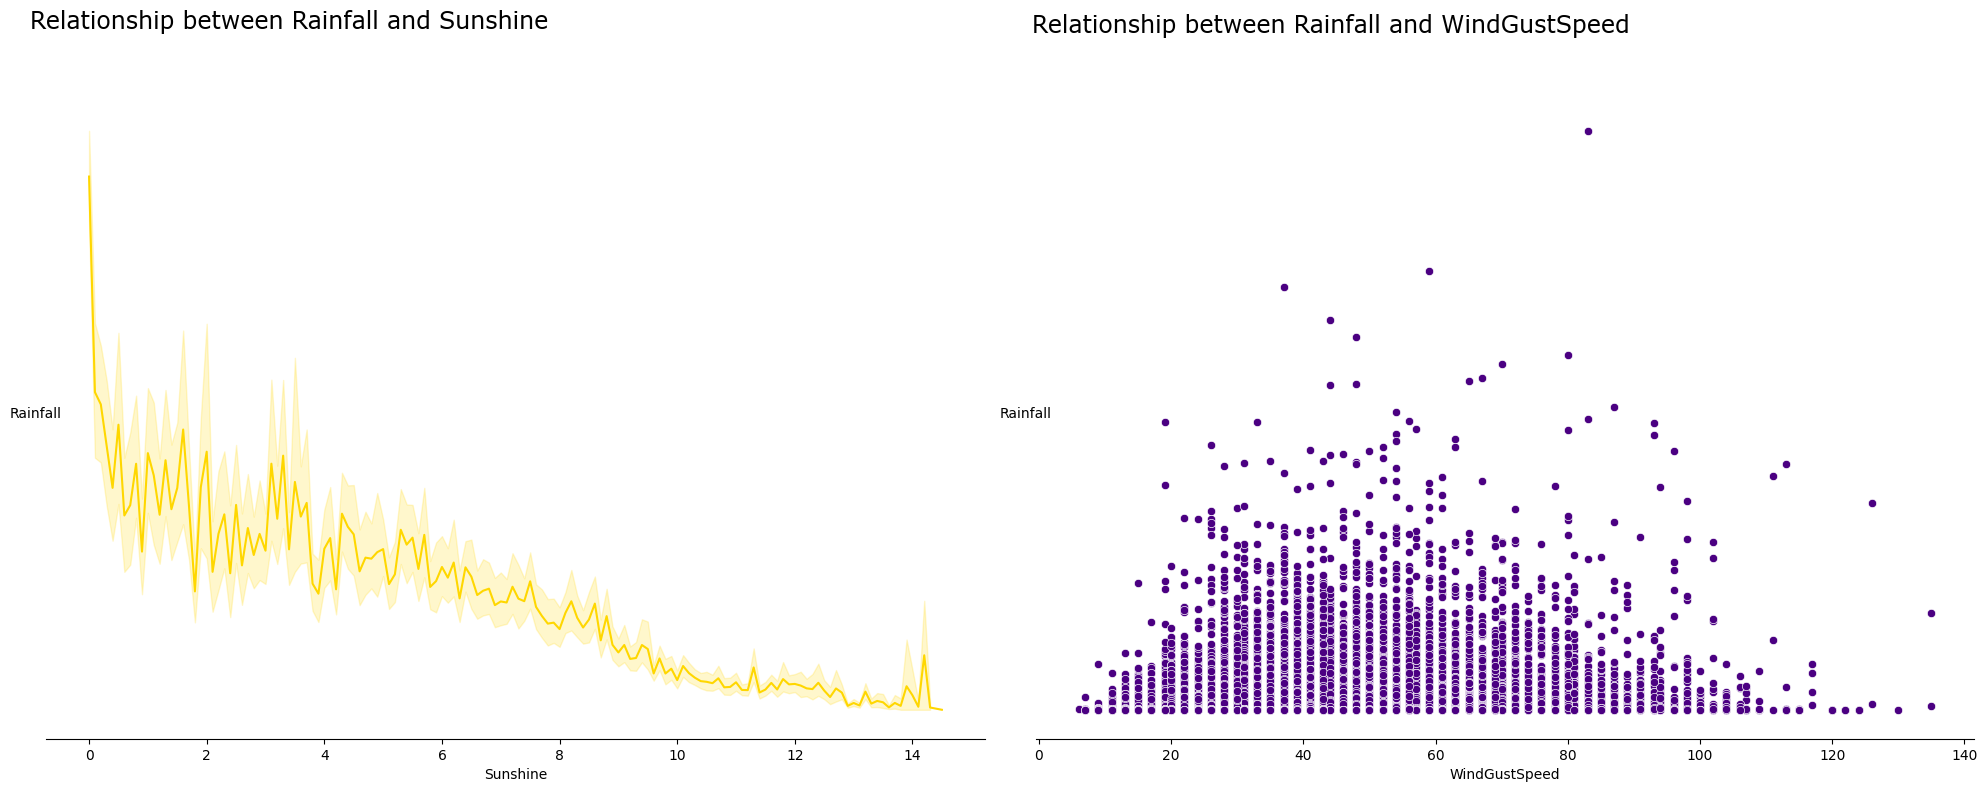

In [39]:
fig=plt.figure(figsize=(20,8),facecolor='white')

gs=fig.add_gridspec(1,2)

ax=[_ for _ in range(2)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])

ax[0].text(-1,15,"Relationship between Rainfall and Sunshine",fontsize=17,fontweight='normal', fontfamily='Verdana')

ax[1].text(-1,430,"Relationship between Rainfall and WindGustSpeed",fontsize=17,fontweight='normal', fontfamily='Verdana')

sns.lineplot(data=class_data,x='Sunshine',y='Rainfall',ax=ax[0],color='#FFD700')
sns.scatterplot(data=class_data,x='WindGustSpeed',y='Rainfall',ax=ax[1],color='#4B0082')

for i in range(2):
    
    ax[i].set_ylabel('Rainfall').set_rotation(0)
    ax[i].set_yticklabels('')
    ax[i].tick_params(axis='y',length=0)
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)
        
plt.tight_layout()
plt.show()

<Axes: xlabel='Cloud3pm', ylabel='Rainfall'>

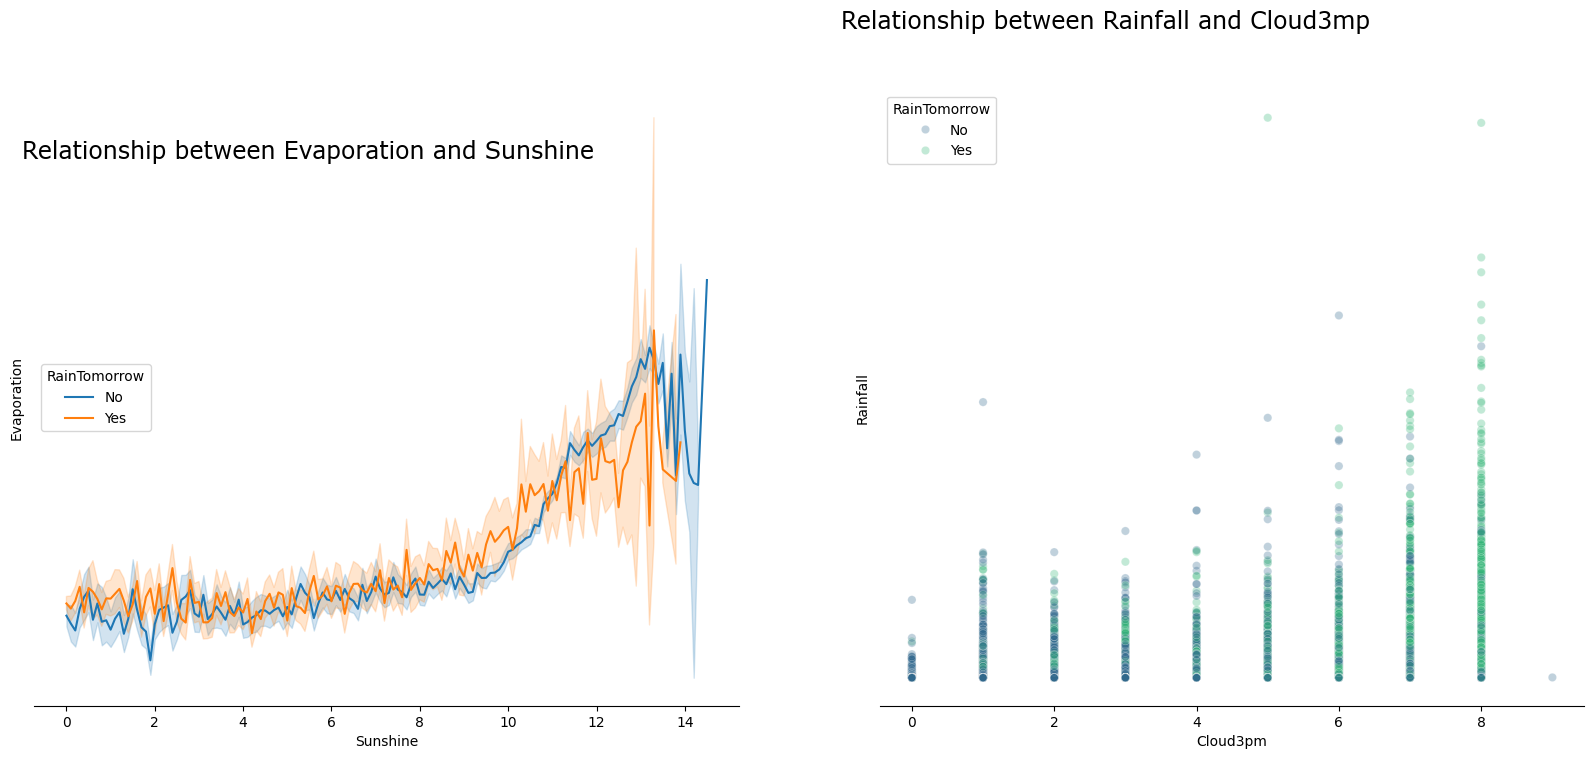

In [40]:
fig=plt.figure(figsize=(20,8),facecolor='white')

gs=fig.add_gridspec(1,2)

ax=[_ for i in range(2)]

ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])

ax[0].text(-1,15,"Relationship between Evaporation and Sunshine",fontsize=17,fontweight='normal', fontfamily='Verdana')

ax[1].text(-1,430,"Relationship between Rainfall and Cloud3mp",fontsize=17,fontweight='normal', fontfamily='Verdana')


for i in range(2):
    ax[i].set_yticklabels([])
    ax[i].tick_params(axis='y',length=0)
    
    for direction in ["top","right", 'left']:
        ax[i].spines[direction].set_visible(False)

sns.lineplot(data=class_data,x='Sunshine',y='Evaporation',ax=ax[0],hue='RainTomorrow')
sns.scatterplot(data=class_data,x='Cloud3pm',y='Rainfall',hue='RainTomorrow',ax=ax[1],palette='viridis',markers='o',alpha=0.3)

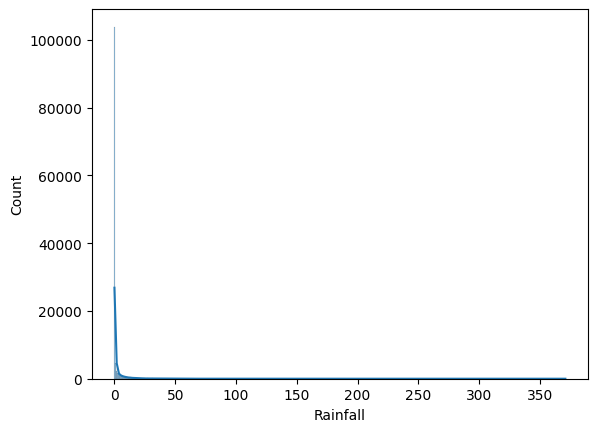

In [41]:
sns.histplot(data = class_data, x = 'Rainfall', bins = 'auto', kde = True);

<Axes: xlabel='MaxTemp', ylabel='Count'>

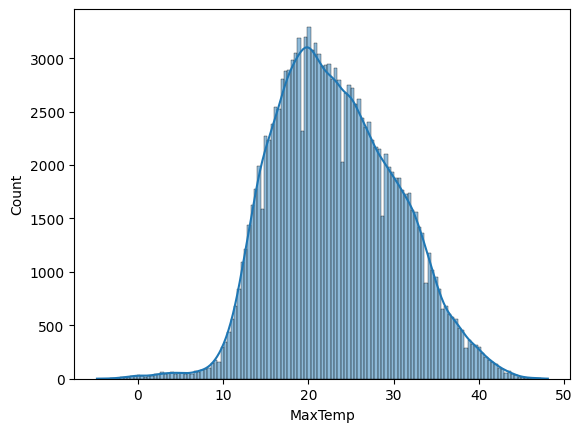

In [42]:
sns.histplot(data = class_data, x = 'MaxTemp', bins = 'auto', kde = True)

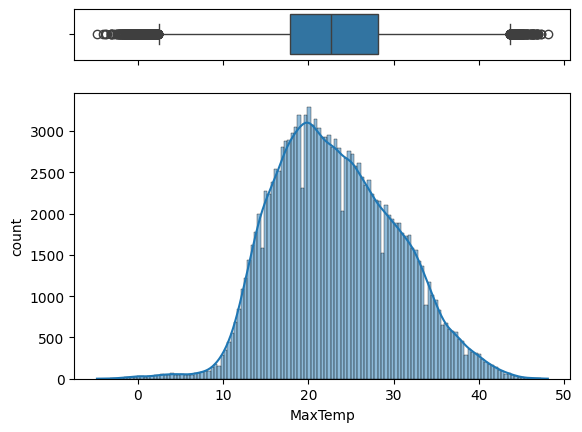

In [43]:
fig, (ax_box, ax_hist) = plt.subplots(2, 
                                    sharex = True, 
                                    gridspec_kw = {'height_ratios': (.15, .85)}) 
 
sns.boxplot(x = class_data['MaxTemp'], ax = ax_box)
sns.histplot(x = class_data['MaxTemp'], ax = ax_hist, bins = 'auto', kde = True)
 
ax_box.set(xlabel = '') 
ax_hist.set(xlabel = 'MaxTemp')
ax_hist.set(ylabel = 'count')
 
plt.show()

<Axes: xlabel='RainTomorrow', ylabel='count'>

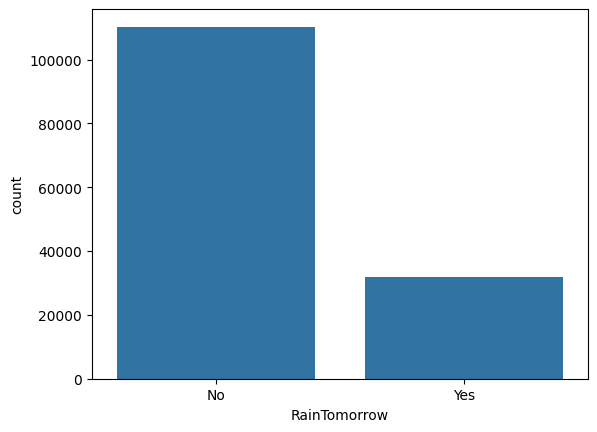

In [44]:
sns.countplot(x = 'RainTomorrow', data = class_data)

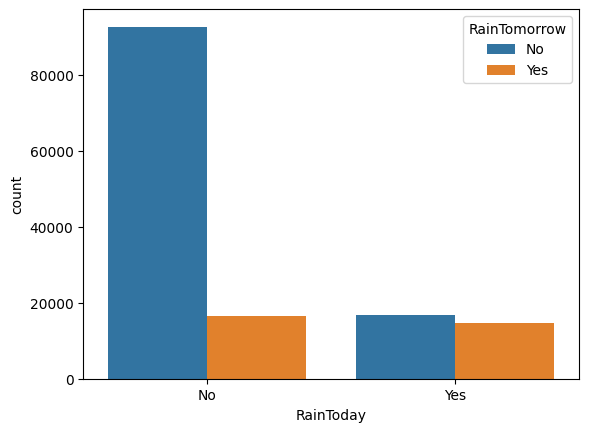

In [45]:
sns.countplot(x = 'RainToday', hue = 'RainTomorrow', data = class_data);

In [46]:
str_cols = class_data.select_dtypes(include=['object']).columns.tolist()

print("Categorical variables:")
print(str_cols)

Categorical variables:
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [47]:
for i in str_cols:
    print(i, class_data[i].isnull().sum())

Date 0
Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [48]:
for i in str_cols:
    class_data[i].fillna(class_data[i].mode()[0], inplace=True)

In [49]:
class_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
class_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [50]:
class_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0


In [51]:
num_cols = class_data.select_dtypes(include=[np.number]).columns.tolist()

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


In [52]:
for i in num_cols:
    print(i, class_data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
RainToday 0
RainTomorrow 0


In [53]:
for i in num_cols:
    class_data[i].fillna(class_data[i].median(), inplace=True)

In [54]:
class_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,4.8,8.4,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,4.8,8.4,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,4.8,8.4,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,4.8,8.4,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,4.8,8.4,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0


In [55]:
class_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        145460 non-null  float64
 3   MaxTemp        145460 non-null  float64
 4   Rainfall       145460 non-null  float64
 5   Evaporation    145460 non-null  float64
 6   Sunshine       145460 non-null  float64
 7   WindGustDir    145460 non-null  object 
 8   WindGustSpeed  145460 non-null  float64
 9   WindDir9am     145460 non-null  object 
 10  WindDir3pm     145460 non-null  object 
 11  WindSpeed9am   145460 non-null  float64
 12  WindSpeed3pm   145460 non-null  float64
 13  Humidity9am    145460 non-null  float64
 14  Humidity3pm    145460 non-null  float64
 15  Pressure9am    145460 non-null  float64
 16  Pressure3pm    145460 non-null  float64
 17  Cloud9am       145460 non-nul

In [56]:
class_data.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [57]:
str_cols=class_data.select_dtypes(include='object').columns.to_list()
print(str_cols)

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [58]:
class_data.drop(columns='Date', inplace=True)

In [59]:
str_cols=class_data.select_dtypes(include='object').columns.to_list()
print(str_cols)

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


<Axes: >

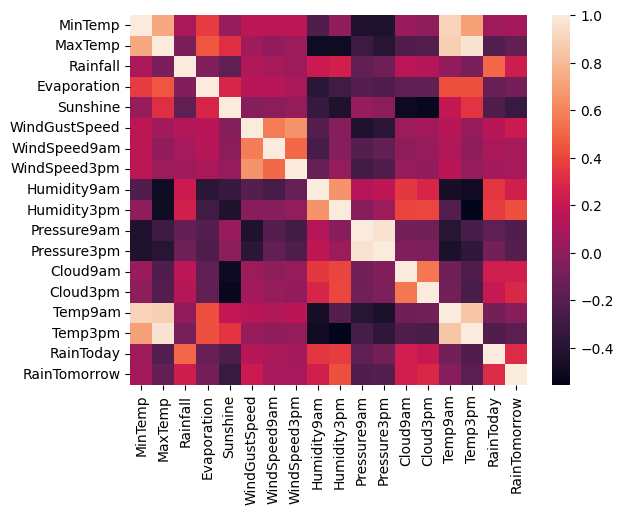

In [60]:
sns.heatmap(class_data.select_dtypes(include=[np.number]).corr())

In [61]:
scaler = StandardScaler()
te = TargetEncoder()

In [62]:
X, y = class_data.drop('RainTomorrow', axis=1), class_data['RainTomorrow']

In [63]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
str_cols = X.select_dtypes(include=['object']).columns.tolist()

In [64]:
transformer = ColumnTransformer(transformers=[
    ('scaler', scaler, num_cols),
    ('cat', te, str_cols)
])

pipe = Pipeline([('preprocessing', transformer), ('model', RandomForestClassifier(n_estimators=100, random_state=42))])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
pipe.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [67]:
y_pred = pipe.predict(X_test)

Accuracy: 0.8529148906915991
F1 (binary): 0.5962064735302444
F1 (macro): 0.753143478848044

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     22672
           1       0.76      0.49      0.60      6420

    accuracy                           0.85     29092
   macro avg       0.81      0.72      0.75     29092
weighted avg       0.84      0.85      0.84     29092


Confusion matrix:
 [[21654  1018]
 [ 3261  3159]]

Class distribution (test):
RainTomorrow
0    22672
1     6420
Name: count, dtype: int64
Baseline (most frequent) accuracy: 0.7793207754709198

ROC AUC: 0.880863704142181

ROC AUC: 0.880863704142181


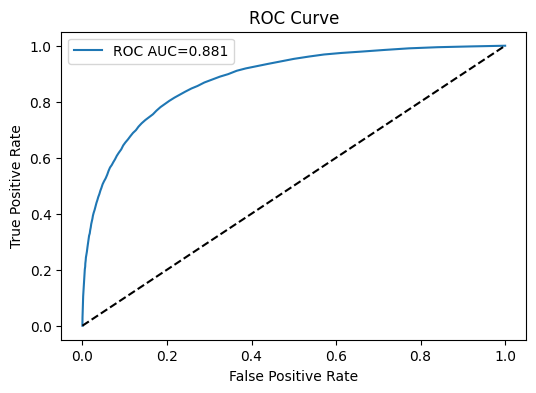

In [68]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 (binary):', f1_score(y_test, y_pred))
print('F1 (macro):', f1_score(y_test, y_pred, average='macro'))
print('\nClassification report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix:\n', cm)

print('\nClass distribution (test):')
print(y_test.value_counts())
print('Baseline (most frequent) accuracy:', y_test.value_counts(normalize=True).max())

y_proba = pipe.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print('\nROC AUC:', auc)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC={auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [69]:
class RandomForestClassifierCustom:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, max_features='sqrt', random_state=None):
        self.n_estimators = int(n_estimators)
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.random_state = random_state
        self.trees_ = []
        self.classes_ = None

    def _gini(self, y):
        """Вычисляет коэффициент Джини"""
        if len(y) == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        p = counts / len(y)
        return 1.0 - np.sum(p ** 2)

    def _build_tree(self, X, y, depth=0):
        """Построить одно дерево решений"""
        node = {}
        n_samples = X.shape[0]
        node['n_samples'] = n_samples
        
        # Наиболее частый класс
        unique_classes, counts = np.unique(y, return_counts=True)
        node['value'] = unique_classes[np.argmax(counts)]
        node['class_counts'] = dict(zip(unique_classes, counts))

        # Критерии остановки
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or len(np.unique(y)) == 1:
            node['is_leaf'] = True
            return node

        best_feat, best_thr, best_gain = None, None, 0.0
        parent_gini = self._gini(y)

        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        if self.max_features == 'sqrt':
            n_features_to_try = max(1, int(np.sqrt(n_features)))
        elif self.max_features == 'log2':
            n_features_to_try = max(1, int(np.log2(n_features)))
        else:
            n_features_to_try = n_features
        
        feature_indices = np.random.choice(n_features, n_features_to_try, replace=False)

        for j in feature_indices:
            xj = X[:, j]
            unique_vals = np.unique(xj)
            
            if len(unique_vals) == 1:
                continue
            
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2.0

            for thr in thresholds:
                left_mask = xj <= thr
                right_mask = ~left_mask
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)

                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue

                gini_left = self._gini(y[left_mask])
                gini_right = self._gini(y[right_mask])
                weighted_gini = (n_left * gini_left + n_right * gini_right) / n_samples
                gain = parent_gini - weighted_gini

                if gain > best_gain:
                    best_gain = gain
                    best_feat = j
                    best_thr = thr

        if best_feat is None or best_gain <= 0:
            node['is_leaf'] = True
            return node

        # Разбиваем данные
        left_mask = X[:, best_feat] <= best_thr
        right_mask = ~left_mask
        node['is_leaf'] = False
        node['feature'] = best_feat
        node['threshold'] = best_thr
        node['left'] = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return node

    def fit(self, X, y):
        X_arr = X.values if hasattr(X, 'values') else np.asarray(X)
        y_arr = y.values if hasattr(y, 'values') else np.asarray(y)

        if X_arr.ndim == 1:
            X_arr = X_arr.reshape(-1, 1)

        self.n_features_in_ = X_arr.shape[1]
        self.classes_ = np.unique(y_arr)
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        n_samples = X_arr.shape[0]
        
        # Обучаем несколько деревьев на случайных подвыборках (bootstrap)
        for i in range(self.n_estimators):
            # Bootstrap sample
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X_arr[indices].astype(float)
            y_bootstrap = y_arr[indices].ravel().astype(int)
            
            # Строим дерево на этой выборке
            tree = self._build_tree(X_bootstrap, y_bootstrap, depth=0)
            self.trees_.append(tree)
        
        return self

    def _predict_row(self, row, tree):
        """Предсказание класса для одной строки на одном дереве"""
        node = tree
        while not node.get('is_leaf', True):
            if row[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node.get('value', self.classes_[0])

    def predict(self, X):
        if not self.trees_:
            raise RuntimeError("Model has not been fitted yet.")
        
        Xq = X.values if hasattr(X, 'values') else np.asarray(X)
        if Xq.ndim == 1:
            Xq = Xq.reshape(1, -1)
        
        # Голосование большинством по всем деревьям
        predictions = []
        for row in Xq:
            tree_preds = [self._predict_row(row, tree) for tree in self.trees_]
            # Найти наиболее частый класс
            unique, counts = np.unique(tree_preds, return_counts=True)
            pred_class = unique[np.argmax(counts)]
            predictions.append(pred_class)
        
        return np.array(predictions, dtype=int)

    def _predict_proba_row(self, row):
        """Возвращает вероятности для каждого класса"""
        proba = np.zeros(len(self.classes_))
        
        for tree in self.trees_:
            node = tree
            while not node.get('is_leaf', True):
                if row[node['feature']] <= node['threshold']:
                    node = node['left']
                else:
                    node = node['right']
            
            class_counts = node.get('class_counts', {})
            for i, cls in enumerate(self.classes_):
                proba[i] += class_counts.get(cls, 0)
        
        # Нормализуем по всем деревьям
        total = len(self.trees_)
        if total > 0:
            proba = proba / total
        
        return proba

    def predict_proba(self, X):
        if not self.trees_:
            raise RuntimeError("Model has not been fitted yet.")
        
        Xq = X.values if hasattr(X, 'values') else np.asarray(X)
        if Xq.ndim == 1:
            Xq = Xq.reshape(1, -1)
        
        proba_result = np.array([self._predict_proba_row(row) for row in Xq])
        return proba_result

In [70]:
pipe_custom = Pipeline([('preprocessing', transformer), ('model', RandomForestClassifierCustom(n_estimators=50, max_depth=10, random_state=42))])
pipe_custom.fit(X_train, y_train)
y_pred_custom = pipe_custom.predict(X_test)

Accuracy (pipe_custom): 0.8432215041935928
F1 (binary): 0.543671835917959
F1 (macro): 0.7245118398498674

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.91     22672
           1       0.76      0.42      0.54      6420

    accuracy                           0.84     29092
   macro avg       0.81      0.69      0.72     29092
weighted avg       0.83      0.84      0.83     29092


Confusion matrix:
 [[21814   858]
 [ 3703  2717]]


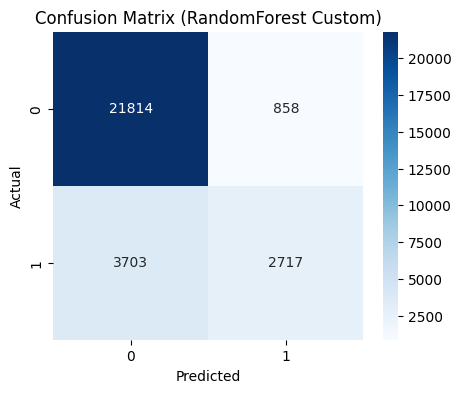


Class distribution (test):
RainTomorrow
0    22672
1     6420
Name: count, dtype: int64
Baseline (most frequent) accuracy: 0.7793207754709198

ROC AUC: 0.48766534729596334

ROC AUC: 0.48766534729596334


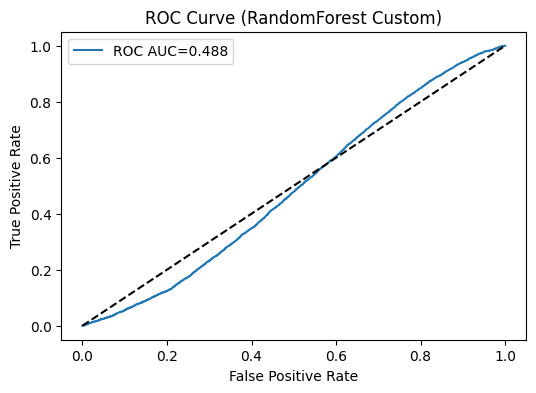

In [71]:
# Оценка качества pipe_custom (Random Forest Custom)
print('Accuracy (pipe_custom):', accuracy_score(y_test, y_pred_custom))
print('F1 (binary):', f1_score(y_test, y_pred_custom))
print('F1 (macro):', f1_score(y_test, y_pred_custom, average='macro'))
print('\nClassification report:\n', classification_report(y_test, y_pred_custom))

# Матрица неточностей и её визуализация
cm = confusion_matrix(y_test, y_pred_custom)
print('\nConfusion matrix:\n', cm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (RandomForest Custom)')
plt.show()

print('\nClass distribution (test):')
print(y_test.value_counts())
print('Baseline (most frequent) accuracy:', y_test.value_counts(normalize=True).max())

y_proba = pipe_custom.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print('\nROC AUC:', auc)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC={auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (RandomForest Custom)')
plt.legend()
plt.show()




In [72]:
# Настроим RandomizedSearch для Random Forest (classification)
model = RandomForestClassifier(random_state=42)

param_dist = {
    'model__n_estimators': list(range(50, 301, 50)),
    'model__max_depth': [None] + list(range(5, 21)),
    'model__min_samples_split': list(range(2, 11)),
    'model__min_samples_leaf': list(range(1, 6)),
    'model__max_features': ['sqrt', 'log2']
}

rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=20, cv=5,
                    scoring='roc_auc', n_jobs=-1, random_state=42)

In [73]:
# Обучаем и выводим лучшие параметры и метрику по CV
rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
print('Best CV score (ROC AUC):', rs.best_score_)

Best params: {'model__n_estimators': 250, 'model__min_samples_split': 7, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': None}
Best CV score (ROC AUC): 0.8827863644128333


In [74]:
# Оценка на тестовой выборке
best_pipe = rs.best_estimator_
y_pred_rs = best_pipe.predict(X_test)

In [75]:
y_proba_rs = best_pipe.predict_proba(X_test)[:, 1]

Accuracy: 0.8528461432696274
F1 (binary): 0.594563879155223
F1 (macro): 0.7523370576878478

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     22672
           1       0.76      0.49      0.59      6420

    accuracy                           0.85     29092
   macro avg       0.81      0.72      0.75     29092
weighted avg       0.84      0.85      0.84     29092


Confusion matrix:
 [[21672  1000]
 [ 3281  3139]]


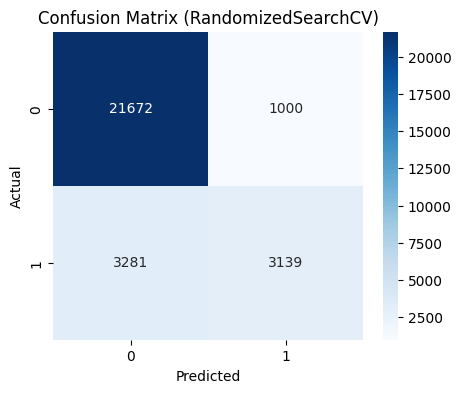


ROC AUC: 0.8836546774590696


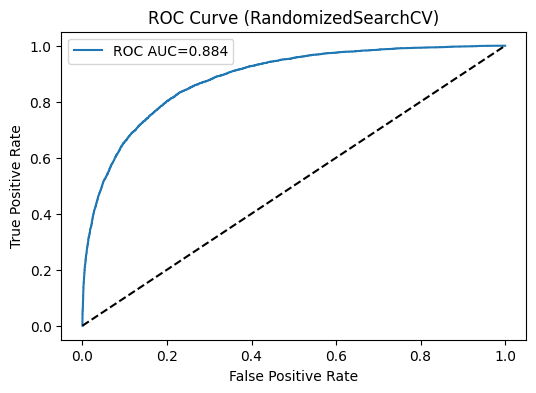

In [76]:
print('Accuracy:', accuracy_score(y_test, y_pred_rs))
print('F1 (binary):', f1_score(y_test, y_pred_rs))
print('F1 (macro):', f1_score(y_test, y_pred_rs, average='macro'))
print('\nClassification report:\n', classification_report(y_test, y_pred_rs))

cm = confusion_matrix(y_test, y_pred_rs)
print('\nConfusion matrix:\n', cm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (RandomizedSearchCV)')
plt.show()

auc = roc_auc_score(y_test, y_proba_rs)
print('\nROC AUC:', auc)
fpr, tpr, _ = roc_curve(y_test, y_proba_rs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC={auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (RandomizedSearchCV)')
plt.legend()
plt.show()